In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
 

import quandl
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [3]:
quandl.ApiConfig.api_key = 'sQ6om9Lq4sexzVxQPXs1'

In [4]:
euro = quandl.get('ECB/EURUSD')

In [5]:
euro.head()

,Value
Date,
1999-01-04,1.1789
1999-01-05,1.1790
1999-01-06,1.1743
1999-01-07,1.1632
1999-01-08,1.1659


### Real DataFrame

In [7]:
df = euro[["Value"]]
df.count()

Value    5271
dtype: int64

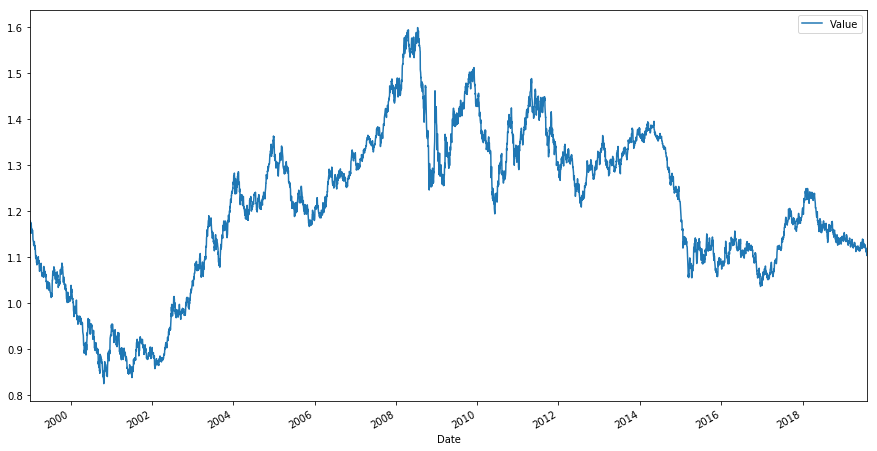

In [8]:
df.plot(figsize=(15,8))

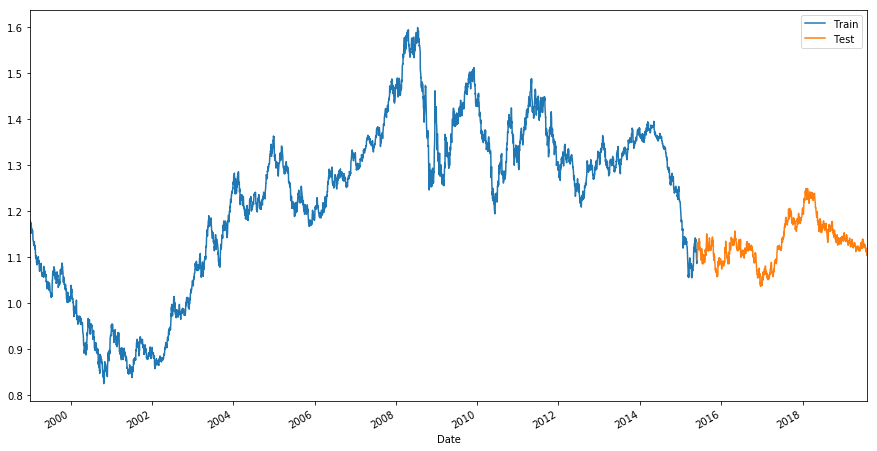

In [9]:
split_date = pd.Timestamp('06-01-2015')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(figsize=(15,8))
test.plot(ax=ax)
plt.legend(['Train', 'Test'])

In [11]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

## ANN

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
X_train 


array([[0.45709486],
       [0.45722409],
       [0.45115017],
       ...,
       [0.33742569],
       [0.34169036],
       [0.35125355]])

In [14]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [15]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
4200/4200 [==============================] - 9s 2ms/step - loss: 0.0022
Epoch 2/200
4200/4200 [==============================] - 8s 2ms/step - loss: 2.1033e-04
Epoch 3/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.8241e-04
Epoch 4/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.7341e-04
Epoch 5/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.6405e-04
Epoch 6/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.7067e-04
Epoch 7/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.6781e-04
Epoch 8/200
4200/4200 [==============================] - 9s 2ms/step - loss: 1.6754e-04
Epoch 9/200
4200/4200 [==============================] - 8s 2ms/step - loss: 1.6749e-04
Epoch 10/200
4200/4200 [==============================] - 7s 2ms/step - loss: 1.6732e-04
Epo

In [16]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.782
The Adjusted R2 score on the Train set is:	0.782

The R2 score on the Test set is:	0.817
The Adjusted R2 score on the Test set is:	0.817


In [17]:
model.save('ANN_NonShift.h5')

## LSTM

In [35]:
train_df = pd.DataFrame(X_train , columns=['Scaled'])
test_df = pd.DataFrame(X_test , columns=['Scaled'])

In [36]:
for s in range(1,2):
    train_df['shift_{}'.format(s)] = train_df['Scaled'].shift(s)
    test_df['shift_{}'.format(s)] = test_df['Scaled'].shift(s)


In [37]:
X_train_t = train_df.dropna().drop('Scaled', axis=1)
y_train_t = train_df.dropna()[['Scaled']]

X_test_t = test_df.dropna().drop('Scaled', axis=1)
y_test_t = test_df.dropna()[['Scaled']]

In [38]:
X_train_t = X_train_t.values
X_test_t = X_test_t.values

y_train_t = y_train_t.values
y_test_t = y_test_t.values


In [39]:
X_tr_t = X_train_t.reshape(X_train_t.shape[0],1,X_train_t.shape[1])
X_tst_t = X_test_t.reshape(X_test_t.shape[0],1,X_test_t.shape[1])

In [40]:
X_tr_t.shape


(4199, 1, 1)

In [41]:
X_tst_t.shape


(1067, 1, 1)

## RELU VS TANH

In [69]:
import keras
from keras.layers import LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
K.clear_session()  
for x in range(2):
    if x == 0:
        K.clear_session()  
        act_c = 'relu'
        model_lstm = Sequential()
        model_lstm.add(LSTM(11, input_shape=(1, X_tr_t.shape[2]), activation= act_c, kernel_initializer='lecun_uniform', return_sequences=False))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mean_squared_error', optimizer='adam')
        model_lstm.summary()
        early_stop = EarlyStopping(monitor='loss', patience=8, verbose=1)
        history_model_lstm = model_lstm.fit(X_tr_t, y_train_t, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])
        y_pred_test_lstm = model_lstm.predict(X_tst_t)
        y_train_pred_lstm = model_lstm.predict(X_tr_t)
        print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_t, y_train_pred_lstm)))
        r2_train = r2_score(y_train_t, y_train_pred_lstm)
        print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train_t.shape[0], X_train_t.shape[1])))
        print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_t, y_pred_test_lstm)))
        r2_test = r2_score(y_test_t, y_pred_test_lstm)
        print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test_t.shape[0], X_test_t.shape[1])))
        model_lstm.save('LSTM_relu.h5')
    else:
        K.clear_session()  
        act_c = 'tanh'
        model_lstm = Sequential()
        model_lstm.add(LSTM(7, input_shape=(1, X_tr_t.shape[2]), activation= act_c, kernel_initializer='lecun_uniform', return_sequences=False))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mean_squared_error', optimizer='adam')
        model_lstm.summary()
        early_stop = EarlyStopping(monitor='loss', patience=8, verbose=1)
        history_model_lstm = model_lstm.fit(X_tr_t, y_train_t, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])
        y_pred_test_lstm = model_lstm.predict(X_tst_t)
        y_train_pred_lstm = model_lstm.predict(X_tr_t)
        print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_t, y_train_pred_lstm)))
        r2_train = r2_score(y_train_t, y_train_pred_lstm)
        print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train_t.shape[0], X_train_t.shape[1])))
        print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_t, y_pred_test_lstm)))
        r2_test = r2_score(y_test_t, y_pred_test_lstm)
        print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test_t.shape[0], X_test_t.shape[1])))
        model_lstm.save('LSTM_tanh.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11)                572       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4199/4199 [==============================] - 34s 8ms/step - loss: 0.0021
Epoch 2/200
4199/4199 [==============================] - 26s 6ms/step - loss: 2.0520e-04
Epoch 3/200
3487/4199 [=======================>......] - ETA: 4s - loss: 2.0751e-04

KeyboardInterrupt: 

## Rolling Windows

In [73]:
train_df = pd.DataFrame(X_train , columns=['Scaled'])
test_df = pd.DataFrame(X_test , columns=['Scaled'])
for n in range(2,4):
    for s in range(1,n):
        train_df['shift_{}'.format(s)] = train_df['Scaled'].shift(s)
        test_df['shift_{}'.format(s)] = test_df['Scaled'].shift(s)
    X_train_tr = train_df.dropna().drop('Scaled', axis=1)
    y_train_tr = train_df.dropna()[['Scaled']]

    X_test_tr = test_df.dropna().drop('Scaled', axis=1)
    y_test_tr = test_df.dropna()[['Scaled']]
    X_train_tr = X_train_tr.values
    X_test_tr = X_test_tr.values

    y_train_tr = y_train_tr.values
    y_test_tr = y_test_tr.values
    X_tr_tr = X_train_tr.reshape(X_train_tr.shape[0],1,X_train_tr.shape[1])
    X_tst_tr = X_test_tr.reshape(X_test_tr.shape[0],1,X_test_tr.shape[1])
    X_tr_tr.shape

    K.clear_session()
    model_lstm = Sequential()
    model_lstm.add(LSTM(7, input_shape=(1, X_tr_tr.shape[2]), activation= 'tanh', kernel_initializer='lecun_uniform', return_sequences=False))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=8, verbose=1)
    history_model_lstm = model_lstm.fit(X_tr_tr, y_train_tr, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    y_pred_test_lstm = model_lstm.predict(X_tst_tr)
    y_train_pred_lstm = model_lstm.predict(X_tr_tr)
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_tr, y_train_pred_lstm)))
    r2_train = r2_score(y_train_tr, y_train_pred_lstm)
    print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train_tr.shape[0], X_train_tr.shape[1])))
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_tr, y_pred_test_lstm)))
    r2_test = r2_score(y_test_tr, y_pred_test_lstm)
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test_tr.shape[0], X_test_tr.shape[1])))
    if X_tr_tr.shape[2] == 1:
        model_lstm.save('LSTM_NonShift.h5')
    else:
        model_lstm.save('LSTM_Shift.h5')          

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1a447d36d8>>
Traceback (most recent call last):
  File "/Users/haifengwan/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Users/haifengwan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140301075445344


Epoch 1/200
4199/4199 [==============================] - 30s 7ms/step - loss: 0.0022
Epoch 2/200
4199/4199 [==============================] - 25s 6ms/step - loss: 2.1807e-04
Epoch 3/200
4199/4199 [==============================] - 27s 6ms/step - loss: 1.9337e-04
Epoch 4/200
4199/4199 [==============================] - 26s 6ms/step - loss: 1.8546e-04
Epoch 5/200
4199/4199 [==============================] - 28s 7ms/step - loss: 1.8230e-04
Epoch 6/200
4199/4199 [==============================] - 30s 7ms/step - loss: 1.8126e-04
Epoch 7/200
4199/4199 [==============================] - 31s 7ms/step - loss: 1.8111e-04
Epoch 8/200
4199/4199 [==============================] - 30s 7ms/step - loss: 1.8117e-04
Epoch 9/200
4199/4199 [==============================] - 31s 7ms/step - loss: 1.8098e-04
Epoch 10/200
4199/4199 [==============================] - 31s 7ms/step - loss: 1.8080e-04
Epoch 11/200
4199/4199 [==============================] - 29s 7ms/step - loss: 1.8048e-04
Epoch 12/200
4199/4199 

Epoch 61/200
4198/4198 [==============================] - 42s 10ms/step - loss: 1.6062e-04
Epoch 62/200
4198/4198 [==============================] - 41s 10ms/step - loss: 1.6043e-04
Epoch 63/200
4198/4198 [==============================] - 40s 10ms/step - loss: 1.6016e-04
Epoch 64/200
4198/4198 [==============================] - 39s 9ms/step - loss: 1.5992e-04
Epoch 65/200
4198/4198 [==============================] - 40s 10ms/step - loss: 1.5969e-04
Epoch 66/200
4198/4198 [==============================] - 30s 7ms/step - loss: 1.5945e-04
Epoch 67/200
4198/4198 [==============================] - 33s 8ms/step - loss: 1.5927e-04
Epoch 68/200
4198/4198 [==============================] - 46s 11ms/step - loss: 1.5902e-04
Epoch 69/200
4198/4198 [==============================] - 30s 7ms/step - loss: 1.5889e-04
Epoch 70/200
4198/4198 [==============================] - 31s 7ms/step - loss: 1.5862e-04
Epoch 71/200
4198/4198 [==============================] - 38s 9ms/step - loss: 1.5845e-04
Epoch

## Predictions made by each Model

In [74]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm_relu = load_model('LSTM_relu.h5')
model_lstm_tanh = load_model('LSTM_tanh.h5')
model_lstm_nons = load_model('LSTM_NonShift.h5')
model_lstm_shift= load_model('LSTM_Shift.h5')

In [75]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_model_lstm_relu= model_lstm_relu.evaluate(X_tst_t, y_test_t, batch_size=1)
score_model_lstm_tanh= model_lstm_tanh.evaluate(X_tst_t, y_test_t, batch_size=1)
score_model_lstm_nons= model_lstm_nons.evaluate(X_tst_t, y_test_t, batch_size=1)
score_model_lstm_shift= model_lstm_shift.evaluate(X_tst_tr, y_test_tr, batch_size=1)

1066/1066 [==============================] - 2s 2ms/step


In [77]:
print('ANN: %f'%score_ann)
print('LSTM RELU: %f'%score_model_lstm_relu)
print('LSTM TANH: %f'%score_model_lstm_tanh)
print('LSTM NONSHIFT: %f'%score_model_lstm_nons)
print('LSTM SHIFT: %f'%score_model_lstm_shift)

ANN: 0.000609
LSTM RELU: 0.000459
LSTM TANH: 0.000118
LSTM NONSHIFT: 0.000182
LSTM SHIFT: 0.000124


In [78]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM_relu = model_lstm_relu.predict(X_tst_t)
y_pred_test_LSTM_tanh = model_lstm_tanh.predict(X_tst_t)
y_pred_test_LSTM_nons = model_lstm_nons.predict(X_tst_t)
y_pred_test_LSTM_shift = model_lstm_shift.predict(X_tst_tr)

In [79]:
col1 = pd.DataFrame(y_test, columns=['True Value'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM_relu, columns=['LSTM Relu Prediction'])
col4 = pd.DataFrame(y_pred_test_LSTM_tanh, columns=['LSTM Tanh Prediction'])
col5 = pd.DataFrame(y_pred_test_LSTM_nons, columns=['LSTM Nonshift Prediction'])
col6 = pd.DataFrame(y_pred_test_LSTM_shift, columns=['LSTM Shift Prediction'])
results = pd.concat([col1, col2, col3, col4, col5, col6], axis=1)
results.to_excel('Euro Forecast.xlsx')


### ANN's Prediction Visual

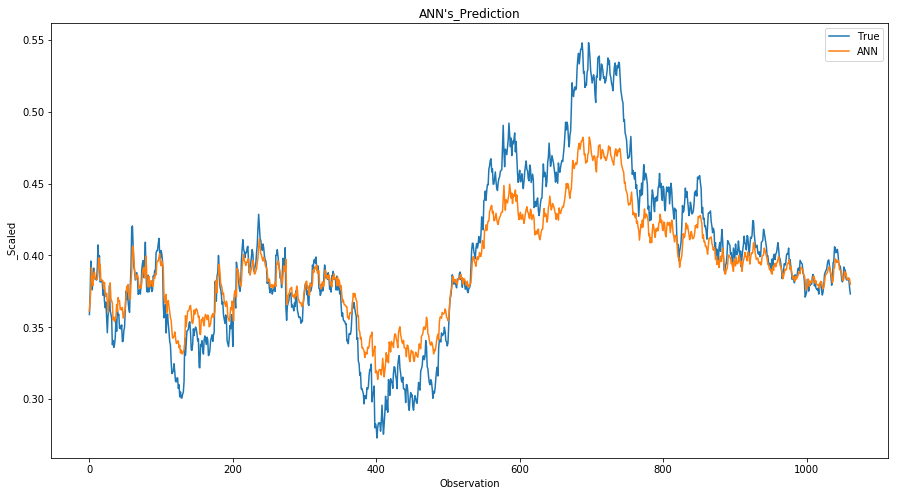

In [57]:
plt.figure(figsize=(15,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('_Scaled')
plt.legend()
plt.show()

### LSTM's Prediction Visual

In [ ]:
plt.figure(figsize=(5,10))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction with tanh Function")
plt.xlabel('Observation')
plt.ylabel('EURO_Scaled')
# plt.xlim(0,400)
plt.legend()
plt.show()

In [ ]:
3,11
3,13
3,15
4,10